# MATH 693A Advanced Numerical Methods: Computational Optimization HW 3
### By Will McGrath

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 1
### Write a Program that implements the dogleg method. Choose $B_k$ to be the exact Hessian. Apply it to solve Rosenbrock’s function: $f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2$. 
### Use an initial trust region radius of 1. Set maximum trust region radius to 300. Use the initial point: $x_0 = [-1.2, 1]$ and then try another point $x_0 = [2.8, 4]$. Do the following for each of the initial points.

### Here are the parameters you should use for the Dogleg Algorithm:
### a. Use $\| \nabla{f(x_k)} \|< 10^{-8}$ as the stopping criteria for your optimization algorithm.
### b. State the total number of iterations obtained in your optimization algorithm.
### c. Plot the objective function $f(x)$. On the same figure, plot the $x_k$ values at the different iterates of your optimization algorithm.
### d. Plot the size of the objective function as a function of the iteration number. Use semi-log plot.
### e. You should hand in (i) your code (ii) the first 4 and last 4 values of $x_k$ obtained from your program.
### f. Determine the minimizer of the Rosenbrock function $x^*$.


### Trust-region method uses a quadratic model. At each iteration, the step is calculated by solving the following quadratic problem (sub-problem) using dogleg method:
> Note: radius increases only if $|p_k|$ reaches the trust-region border
- $\bar{p_k} = \argmin_{\| \bar{p} \| \le \Delta{_k}}[f(\bar{x_k}) + \bar{p}^T\nabla{f(\bar{x_k})} + \frac{1}{2}\bar{p}^TB_k\bar{p}]$
    - When the first three terms of the quadratic model agrees with the Taylor expansion: S.T. $B_k = \nabla^2f(\bar{x_k})$, the algorithm is called the trust-region Newton Method. The locally constrained trust region problem is to minimize model $m_k$ whhich is based on the Taylor expansion of the objective $f$ at the current point(where $T_k$ is the trust region and $\bar{p_k}$ is now $\bar{p}$ since $\bar{m_k}$ is being iterated):
- $ \bar{p_k} = \min_{\bar{p} \in T_k} m_k(\bar{p}) = \min_{\bar{p} \in T_k} [f(\bar{x_k}) + \bar{p}^T\nabla{f(\bar{x_k})} + \frac{1}{2}\bar{p}^TB_k\bar{p}]$. The full step is the unconstrained minimum of the quadratic model: 
- $\bar{p_k}^{FS} = -B_k^{-1}\nabla{f(\bar{x_k})}$. The step in the steepest descent direction is given by the unconstrained minimum of the quadratic model along the steepest descent direction:
- $\bar{p_k}^{U} = - \frac{\nabla{f(\bar{x_k})}^T\nabla{f(\bar{x_k})}}  {\nabla{f(\bar{x_k})}^T B_k \nabla{f(\bar{x_k})}} \nabla{f(\bar{x_k})}$

In [2]:
# Rosenbrock function
def objective_func(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]

    return 100*(y - x**2)**2 + (1 - x)**2

def gradient(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]

    return np.array([400*x**3 - 400*x*y + 2*x - 2, 200*(y - x**2)])

def hessian(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]
    
    return np.array([[1200*x**2 - 400*y + 2, -400*x],[-400*x, 200]])

## Part a, b, e, f

### Dogleg Method:
- Quadratic equation $\vert\vert \bar{p_k}^U + (\tau^* - 1)(\bar{p_k}^{FS}  - \bar{p_k}^U) \vert\vert^2 = \Delta_k^2$ where $\tau^* \in [1,2]$ and solve for $\tau$ (only 1 positive root)
- Solving for the $\tau^*$ using the quadratic formula gives $\tau^* = \frac{\Delta_k \ - \ \bar{p_k}^U}{\bar{p_k}^{FS} \ - \ \bar{p_k}^U} - 1$

In [3]:
def dogleg_method(xbar_k, grad, Hk, Bk, trust_region):
    # compute the Newton point - this is the optimum for the quadratic model function
    # if it's inside the trust radius then return this point
    # test if the full step is within the trust region
    
    # compute the Cauchy point - this is the predicted optimum along the direction of steepest descent
    # if Cauchy point is outside the trust region, then return the point where the path intersects the boundary
    U_num = -np.dot(grad(xbar_k), grad(xbar_k))
    U_den = np.dot(grad(xbar_k), np.dot(Bk, grad(xbar_k)))
    pbar_U_k = (U_num / U_den) * grad(xbar_k) # Cauchy point
    pbar_FS_k = -np.dot(Hk, grad(xbar_k)) # Newton point
    
    if np.linalg.norm(pbar_U_k) >= trust_region:
        pbar_DL_k = trust_region * pbar_U_k / np.linalg.norm(pbar_U_k) # where pbar_DL_k = dogleg pbar  

    elif np.linalg.norm(pbar_FS_k) <= trust_region: 
        pbar_DL_k = pbar_FS_k

    else:
        # find the solution to the scalar quadratic equation and compute the intersection of the trust region boundary
        # then line segment connecting the Cauchy and Newton points
        # this requires solving a quadratic equation
        # solve the quadratic equation for positive time t using the quadratic formula
        # tau_star = ((trust_region - pbar_U_k) / (pbar_FS_k - pbar_U_k)) + 1
        
        diff_FS_U_k = pbar_FS_k - pbar_U_k
        dot_pbar_U_k = np.dot(pbar_U_k, pbar_U_k)

        dot_diff_FS_U_k = np.dot(diff_FS_U_k, diff_FS_U_k)
        dot_U_diff_FS_U_k = np.dot(pbar_U_k, diff_FS_U_k)
        
        factor = dot_U_diff_FS_U_k**2 - dot_diff_FS_U_k * (dot_pbar_U_k - trust_region**2)
        tau_star = ((np.sqrt(factor) - dot_U_diff_FS_U_k) / dot_diff_FS_U_k ) + 1

        # decide on which part of the trajectory to take
        pbar_DL_k = pbar_U_k + (tau_star - 1) * (pbar_FS_k - pbar_U_k)

    return pbar_DL_k

### Trust Region: 
- Set $k = 1, \hat{\Delta} > 0, \Delta_0 \in (0, \hat{\Delta}),$ and $\eta \in (0, \frac{1}{4})$ S.T. $\hat{\Delta}$ = max trust region radius, and $\Delta_0$ = initial trust region radius
- Given a step $\bar{p_k}$ we define the ratio: $\rho_k=\frac{actual \ reduction}{predicted \ reduction} = \frac{f(\bar{x_k}) \ - \ f(\bar{x_k} + \bar{p_k})}{m_k(0) \ - \ m_k(\bar{p_k})}$
- If $\rho_k < 0$ We shrink the size of the trust region.
- If $\rho_k ≈ 0$ Then we shrink the size of the trust region.
- If $\rho_k ≈ 1$ Then the model is in good agreement with the objective; in this case it is (probably) safe to expand the trust region for the next iteration.
- Else we keep the size of the trust region.

In [4]:
# trust region algorithm 
def trust_reg_dogleg(x0, obj_func, grad, hess, grad_stop_criteria, eta=0.15, initial_trust_radius=1, max_trust_radius=300):
    xbar_k = x0 # xbar_k = xbar_transposed
    trust_reg = initial_trust_radius
    k = 1
    k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list = [], [], [], [], [], []

    while np.linalg.norm(grad(xbar_k)) > grad_stop_criteria:
        Bk = hess(xbar_k)
        Hk = np.linalg.inv(Bk) # hessian of Bk inverse

        # get approx. step pbar_k by dogleg method (gives minimized pbar_k)
        pbar_k = dogleg_method(xbar_k, grad, Hk, Bk, trust_reg)

        # define a ratio measuring the success of a step
        # given a step pbar_k we define the ratio: rho_k = actual reduction / predicted reduction 
        mk_0 = obj_func(xbar_k)
        mk_pbar_k = obj_func(xbar_k) + np.dot(grad(xbar_k),  pbar_k) + 0.5 * np.dot(pbar_k, np.dot(Bk, pbar_k))
        act_reduc = obj_func(xbar_k) - obj_func(xbar_k + pbar_k)
        pred_reduc = mk_0 - mk_pbar_k
        rho_k = act_reduc / pred_reduc

        # rho is close to zero or negative, therefore the trust region must shrink
        if rho_k < 0.25:
            trust_reg = 0.25 * trust_reg

        # rho is close to one and pbar_k has reached the boundary of the trust region, therefore the trust region must be expanded
        # euclidean norm of pbar_k = sqrt(np.dot(pbar_k, pbar_k)) = np.linalg.norm(pbar_k)
        else:
            if rho_k > 0.75 and np.linalg.norm(pbar_k) == trust_reg:
                trust_reg = min(2 * trust_reg, max_trust_radius)
            else:
                trust_reg = trust_reg
        
        # add to dataframe
        if k == 1:
            xbar_list.append(x0)
            k_list.append(0)
            obj_func_xbar_list.append(obj_func(x0))
            pbar_list.append(np.nan)
            rho_list.append(np.nan)
            trust_reg_list.append(np.nan)

        # choose position for the next iteration
        if rho_k > eta:
            xbar_k = xbar_k + pbar_k
        else:
            xbar_k = xbar_k
        
        xbar_list.append(xbar_k)
        k_list.append(k)
        obj_func_xbar_list.append(obj_func(xbar_k))
        pbar_list.append(pbar_k)
        rho_list.append(rho_k)
        trust_reg_list.append(trust_reg)

        k = k + 1

        trust_reg_dogleg_df = pd.DataFrame(
        [[k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list]], 
        columns=['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']
    ).explode(['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']).reset_index(drop=True)

    return trust_reg_dogleg_df

In [5]:
trust_reg_dogleg_df_1 = trust_reg_dogleg([-1.2, 1], objective_func, gradient, hessian, 10**(-8))
trust_reg_dogleg_df_1

,iteration,xbar,f(xbar),pbar,rho,trust_region
0,0,"[-1.2, 1]",24.2,NaN,NaN,NaN
1,1,"[-1.1752808988764047, 1.3806741573033712]",4.731884,"[0.02471910112359521, 0.3806741573033712]",1.002768,1
2,2,"[-1.1752808988764047, 1.3806741573033712]",4.731884,"[0.3943202579752289, -0.9189730867388609]",-0.41427,0.25
3,3,"[-1.0740775360522827, 1.1520743336965071]",4.302044,"[0.10120336282412198, -0.22859982360686404]",1.020245,0.25
4,4,"[-0.9646493088686416, 0.927295635650083]",3.860905,"[0.10942822718364105, -0.2247786980464241]",1.023918,0.25
5,5,"[-0.8447896455071909, 0.7079017863769554]",3.406576,"[0.11985966336145068, -0.21939384927312752]",1.03042,0.25
6,6,"[-0.711374723653508, 0.49647695664597113]",2.937975,"[0.133414921853683, -0.21142482973098428]",1.040228,0.25
7,7,"[-0.5597758508579551, 0.29768615764582174]",2.457433,"[0.15159887279555284, -0.19879079900014943]",1.054521,0.25
8,8,"[-0.38312189706657995, 0.12078680600801986]",1.980603,"[0.1766539537913752, -0.17689935163780188]",1.0741,0.5
9,9,"[-0.16000592252323131, -0.024178842853917887]",1.593426,"[0.22311597454334864, -0.14496564886193775]",1.029252,0.5


In [15]:
print(f"Initial point: {trust_reg_dogleg_df_1['xbar'].iloc[0]}")
print(f"Minimizer using trust region dogleg method (x*): {trust_reg_dogleg_df_1['xbar'].iloc[-1]}")
print(f"Value of function at xbar: {objective_func(trust_reg_dogleg_df_1['xbar'].iloc[0])}")
print(f"Value of function at x*: {objective_func(trust_reg_dogleg_df_1['xbar'].iloc[-1])}")
print(f"Number of iterations: {len(trust_reg_dogleg_df_1['iteration']) - 1}")

Initial point: [-1.2, 1]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 24.199999999999996
Value of function at x*: 9.357042906077154e-23
Number of iterations: 25


In [7]:
trust_reg_dogleg_df_2 = trust_reg_dogleg([2.8, 4], objective_func, gradient, hessian, 10**(-8))
trust_reg_dogleg_df_2

,iteration,xbar,f(xbar),pbar,rho,trust_region
0,0,"[2.8, 4]",1477.8,NaN,NaN,NaN
1,1,"[2.3761875232684537, 4.905749956978565]",56.730463,"[-0.42381247673154626, 0.9057499569785651]",1.087693,1
2,2,"[2.366957772807828, 5.60240390996183]",1.868574,"[-0.009229750460625574, 0.6966539529832652]",1.00023,1
3,3,"[2.159766704636597, 4.624103413554891]",1.508993,"[-0.20719106817123117, -0.9783004964069392]",0.688603,1
4,4,"[2.032288448487984, 4.113945632067005]",1.092028,"[-0.1274782561486132, -0.5101577814878855]",1.337373,1
5,5,"[1.7896159404369696, 3.143837362936064]",0.970271,"[-0.24267250805101429, -0.9701082691309411]",0.439342,1
6,6,"[1.7278189067287881, 2.981539301074335]",0.531179,"[-0.06179703370818146, -0.1622980618617289]",1.110014,1
7,7,"[1.7278189067287881, 2.981539301074335]",0.531179,"[-0.2791690806294775, -0.9602419613933211]",-0.989425,0.25
8,8,"[1.6568643871640618, 2.7418197646294744]",0.432613,"[-0.07095451956472634, -0.23971953644486055]",1.031141,0.25
9,9,"[1.5832829792125747, 2.502893465524757]",0.341733,"[-0.07358140795148704, -0.23892629910471735]",1.026861,0.25


In [16]:
print(f"Initial point: {trust_reg_dogleg_df_2['xbar'].iloc[0]}")
print(f"Minimizer using trust region dogleg method (x*): {trust_reg_dogleg_df_2['xbar'].iloc[-1]}")
print(f"Value of function at xbar: {objective_func(trust_reg_dogleg_df_2['xbar'].iloc[0])}")
print(f"Value of function at x*: {objective_func(trust_reg_dogleg_df_2['xbar'].iloc[-1])}")
print(f"Number of iterations: {len(trust_reg_dogleg_df_2['iteration']) - 1}")

Initial point: [2.8, 4]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 1477.7999999999993
Value of function at x*: 2.1476738144642046e-28
Number of iterations: 23


## Part c

In [9]:
def contourplot(objective_func, x_range, y_range, title, ncontours=500):
    xmin = x_range[0]
    xmax = x_range[1]
    ymin = y_range[0]
    ymax = y_range[1]

    # range of x and y 
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x,y)
    xbar = [X,Y]
    Z = objective_func(xbar)

    plt.figure(figsize=(10, 7))
    plt.contour(X, Y, Z, ncontours, cmap = 'hsv'); # plot the contours
    plt.scatter(1, 1, marker="x", s=150, color="black", label = 'Minimum');  # mark the minimum
    plt.legend(loc=0)
    plt.title("Minimize $f(x,y)=100(y-x^2)^2 + (1-x)^2$ with %s"%title);
    plt.xlabel('x')
    plt.ylabel('y')

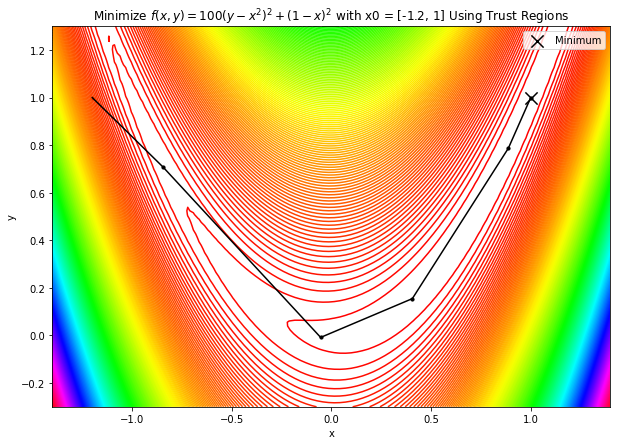

In [10]:
# plot objective function
contourplot(objective_func, [-1.4, 1.4], [-0.3, 1.3], "x0 = [-1.2, 1] Using Trust Regions")

# plot random iterations
xbar_list_1 = trust_reg_dogleg_df_1['xbar'].to_list()
pt1 = xbar_list_1[0]
pt2 = xbar_list_1[5]
pt3 = xbar_list_1[10]
pt4 = xbar_list_1[15]
pt5 = xbar_list_1[20]
pt6 = xbar_list_1[25]
all_pts = [pt1, pt2, pt3, pt4, pt5, pt6]

for pt in all_pts:
    plt.scatter(pt[0], pt[1], marker='o', s=10, color='black');

for i in range(1, len(all_pts)):
    plt.plot((all_pts[i-1][0], all_pts[i][0]), (all_pts[i-1][1], all_pts[i][1]), color='black');

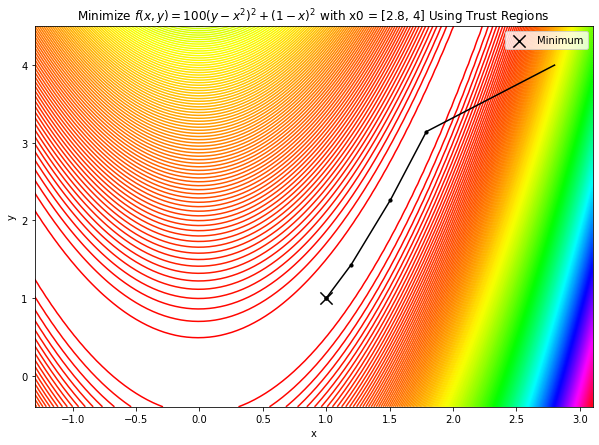

In [11]:
# plot objective function
contourplot(objective_func, [-1.3, 3.1], [-0.4, 4.5], "x0 = [2.8, 4] Using Trust Regions")

# plot random iterations
xbar_list_2 = trust_reg_dogleg_df_2['xbar'].to_list()
pt1 = xbar_list_2[0]
pt2 = xbar_list_2[5]
pt3 = xbar_list_2[10]
pt4 = xbar_list_2[15]
pt5 = xbar_list_2[20]
pt6 = xbar_list_2[23]
all_pts = [pt1, pt2, pt3, pt4, pt5, pt6]

for pt in all_pts:
    plt.scatter(pt[0], pt[1], marker='o', s=10, color='black');

for i in range(1, len(all_pts)):
    plt.plot((all_pts[i-1][0], all_pts[i][0]), (all_pts[i-1][1], all_pts[i][1]), color='black');

## Part d

In [12]:
# semi-log plots
def plot_semilogy(xbar_list_1, xbar_list_2):
    indx_list_1 = np.linspace(1, len(xbar_list_1), len(xbar_list_1))
    indx_list_2 = np.linspace(1, len(xbar_list_2), len(xbar_list_2))

    plt.figure(figsize=(13, 8))
    plt.semilogy(indx_list_1, xbar_list_1, label="x0 = [-1.2, 1]");
    plt.semilogy(indx_list_2, xbar_list_2, label="x0 = [2.8, 4]");
    plt.xlabel('Iteration')
    plt.ylabel('Log of f(xbar)')
    plt.title('Algorithm Convergence')
    plt.xticks(np.arange(0,27))
    plt.legend(loc=0)

    return None

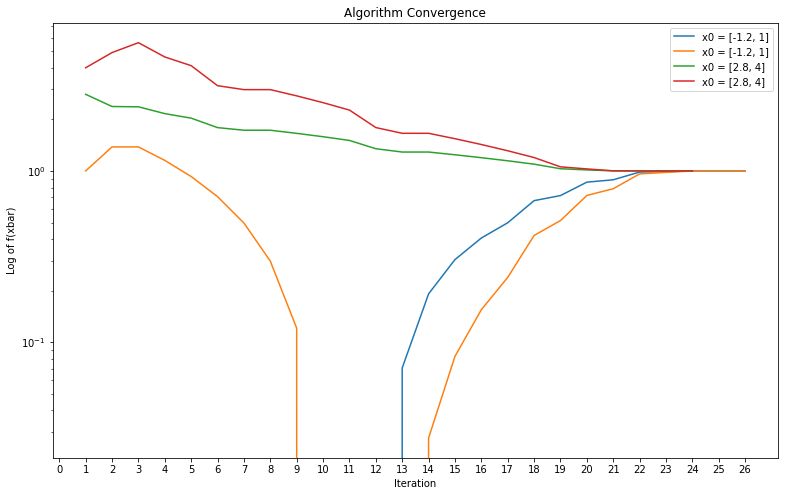

In [13]:
plot_semilogy(xbar_list_1, xbar_list_2)

# Problem 2
###  Experiment with the update rule for the trust region by changing the constants in Algorithm 4.1 in the text Numerical Optimization by Nocedal and Wright 2006. State what you experimented with and discuss your observations.

### What I notice is that as $\rho_k$ (rho) decreases, the number of iterations generally increases after a certain value of $\rho_k$. In this case, after $[0.667, 0.833]$. This means that $\rho_k$ (rho) and number of iterations are inversely proportional. The reason for this is because updating the trust radius becomes harder as $\rho_k$ (rho) decreases. I also noticed that $\rho_k$ must be less than 1 or else the algorithm does not work. It seems that the best number of iterations we get for $x_0 = [-1.2, 1]$ is 23 and 17 for $x_0 = [2.8, 4]$.

In [17]:
# trust region algorithm 
def trust_reg_dogleg_test(x0, obj_func, grad, hess, grad_stop_criteria, update, eta=0.15, initial_trust_radius=1, max_trust_radius=300):
    xbar_k = x0 # xbar_k = xbar_transposed
    trust_reg = initial_trust_radius
    k = 1
    k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list = [], [], [], [], [], []

    while np.linalg.norm(grad(xbar_k)) > grad_stop_criteria:
        Bk = hess(xbar_k)
        Hk = np.linalg.inv(Bk) # hessian of Bk inverse

        # get approx. step pbar_k by dogleg method (gives minimized pbar_k)
        pbar_k = dogleg_method(xbar_k, grad, Hk, Bk, trust_reg)

        # define a ratio measuring the success of a step
        # given a step pbar_k we define the ratio: rho_k = actual reduction / predicted reduction 
        mk_0 = obj_func(xbar_k)
        mk_pbar_k = obj_func(xbar_k) + np.dot(grad(xbar_k),  pbar_k) + 0.5 * np.dot(pbar_k, np.dot(Bk, pbar_k))
        act_reduc = obj_func(xbar_k) - obj_func(xbar_k + pbar_k)
        pred_reduc = mk_0 - mk_pbar_k
        rho_k = act_reduc / pred_reduc

        # rho is close to zero or negative, therefore the trust region must shrink
        if rho_k < (1 / update):
            trust_reg = (1 / update) * trust_reg

        # rho is close to one and pbar_k has reached the boundary of the trust region, therefore the trust region must be expanded
        # euclidean norm of pbar_k = sqrt(np.dot(pbar_k, pbar_k)) = np.linalg.norm(pbar_k)
        else:
            if rho_k > ((update - 1) / update) and np.linalg.norm(pbar_k) == trust_reg:
                trust_reg = min(2 * trust_reg, max_trust_radius)
            else:
                trust_reg = trust_reg
        
        # add to dataframe
        if k == 1:
            xbar_list.append(x0)
            k_list.append(0)
            obj_func_xbar_list.append(obj_func(x0))
            pbar_list.append(np.nan)
            rho_list.append(np.nan)
            trust_reg_list.append(np.nan)

        # choose position for the next iteration
        if rho_k > eta:
            xbar_k = xbar_k + pbar_k
        else:
            xbar_k = xbar_k
        
        xbar_list.append(xbar_k)
        k_list.append(k)
        obj_func_xbar_list.append(obj_func(xbar_k))
        pbar_list.append(pbar_k)
        rho_list.append(rho_k)
        trust_reg_list.append(trust_reg)

        k = k + 1

        trust_reg_dogleg_df = pd.DataFrame(
        [[k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list]], 
        columns=['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']
    ).explode(['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']).reset_index(drop=True)

    return trust_reg_dogleg_df

In [35]:
vals = [1.2, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 20]
for val in vals:
    trust_reg_dogleg_test_df = trust_reg_dogleg_test([-1.2, 1], objective_func, gradient, hessian, 10**(-8), val)
    print(f"Initial point: {trust_reg_dogleg_test_df['xbar'].iloc[0]}")
    print(f"Minimizer using trust region dogleg method (x*): {trust_reg_dogleg_test_df['xbar'].iloc[-1]}")
    print(f"Value of function at xbar: {objective_func(trust_reg_dogleg_test_df['xbar'].iloc[0])}")
    print(f"Value of function at x*: {objective_func(trust_reg_dogleg_test_df['xbar'].iloc[-1])}" )
    print(f"Update constants: {[(1 / val), (val - 1 / val)]}")
    print(f"Number of iterations: {len(trust_reg_dogleg_test_df['iteration']) - 1}")
    print("*"*65, end="\n"*2)

Initial point: [-1.2, 1]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 24.199999999999996
Value of function at x*: 4.082848222584499e-28
Update constants: [0.8333333333333334, 0.3666666666666666]
Number of iterations: 26
*****************************************************************

Initial point: [-1.2, 1]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 24.199999999999996
Value of function at x*: 2.025766071778896e-21
Update constants: [0.6666666666666666, 0.8333333333333334]
Number of iterations: 23
*****************************************************************

Initial point: [-1.2, 1]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 24.199999999999996
Value of function at x*: 6.624089673044124e-28
Update constants: [0.5, 1.5]
Number of iterations: 25
*****************************************************************

Initial point: [-1.2, 1]
Minimizer using trust regio

In [36]:
vals = [1.2, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 20, 50, 100, 300]
for val in vals:
    trust_reg_dogleg_test_df = trust_reg_dogleg_test([2.8, 4], objective_func, gradient, hessian, 10**(-8), val)
    print(f"Initial point: {trust_reg_dogleg_test_df['xbar'].iloc[0]}")
    print(f"Minimizer using trust region dogleg method (x*): {trust_reg_dogleg_test_df['xbar'].iloc[-1]}")
    print(f"Value of function at xbar: {objective_func(trust_reg_dogleg_test_df['xbar'].iloc[0])}")
    print(f"Value of function at x*: {objective_func(trust_reg_dogleg_test_df['xbar'].iloc[-1])}" )
    print(f"Update constants: {[(1 / val), (val - 1 / val)]}")
    print(f"Number of iterations: {len(trust_reg_dogleg_test_df['iteration']) - 1}")
    print("*"*65, end="\n"*2)

Initial point: [2.8, 4]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 1477.7999999999993
Value of function at x*: 8.2539502589406e-28
Update constants: [0.8333333333333334, 0.3666666666666666]
Number of iterations: 23
*****************************************************************

Initial point: [2.8, 4]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 1477.7999999999993
Value of function at x*: 9.975343361746e-27
Update constants: [0.6666666666666666, 0.8333333333333334]
Number of iterations: 17
*****************************************************************

Initial point: [2.8, 4]
Minimizer using trust region dogleg method (x*): [1. 1.]
Value of function at xbar: 1477.7999999999993
Value of function at x*: 5.07299191815331e-26
Update constants: [0.5, 1.5]
Number of iterations: 18
*****************************************************************

Initial point: [2.8, 4]
Minimizer using trust region dogleg m

### Resource:
- [Example](https://sudonull.com/post/68061-Optimization-method-Trust-Region-DOGLEG-Python-implementation-example)